In [2]:
import pickle

with open("cleaned_text.pkl", "rb") as f:
    cleaned_text = pickle.load(f)

cleaned_text[:3]

["Translated in English: Ramananda Prasad, Ph.D. Language Editors: Needed Contact: rprasad@gita-society.com  \n*****  \n'Let noble thoughts come to us from everywhere' (The Vedas)",
 "The Bhagavad-Gita is a doctrine of universal truth and a book of moral and spiritual growth. Its message is sublime and non-sectarian. It deals with the most sacred metaphysical science. It imparts the knowledge of the Self and answers two universal questions: Who am I, and how can I lead a happy and peaceful life in this word full of dualities and dilemmas?  \nIt's a timeless book of wisdom that inspired Thoreau, Emerson, Einstein, Oppenheimer, Gandhi and many others. The BhagavadGita teaches us how to equip ourselves for the battle of life. A repeated study with faith purifies our psyche and guides us to face the challenges of modern living leading to inner peace and happiness.  \nGita teaches the spiritual science of Self-realization (SR) based on the essence of Upanishads and Vedanta. The prime messag

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from IPython.display import  clear_output
import time
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"

# Configure 4-bit quantization
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Normalized float 4-bit (recommended)
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True  # Improves performance by applying second quantization
)

model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    #quantization_config=bnb_config,
    # torch_dtype=torch.bfloat16,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = 128001

/root/invest-rag/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


In [4]:
!nvidia-smi

Thu May 15 11:22:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:C1:00.0 Off |                  N/A |
| 30%   37C    P0            112W /  350W |   14026MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
model.get_memory_footprint()/(1024*1024*1024)# Gbs

11.968425989151001

In [6]:
pdf_path = "stock-market.pdf"
pdf_reader = PyPDF2.PdfReader(pdf_path)
# Get total number of pages
num_pages = len(pdf_reader.pages)
print(f"Processing PDF with {num_pages} pages...")

full_text = []

for page_num in range(4,num_pages-1):
    page = pdf_reader.pages[page_num]
    text = page.extract_text()
    full_text.append(text)

full_text = '\n'.join(full_text)


Processing PDF with 15 pages...


In [7]:
print(full_text)

Short & Long Term Options 
for Investment 
•Short Term: 
1. Savings Bank Account 2. Money Market or Liquid Funds 
3. Fixed Deposit with Banks 
3. Fixed Deposit with Banks 
•Long Term:
1. Post Office Savings 2. Public Provident Fund 3. Bonds 4. Mutual Funds 
Before investing in a Market 
•Before investing, it is always wise to learn the Basics 
of Stock Market . We have compiled articles and 
tutorials on the Share Market Basics .Also included 
here explanation of Stock Market Terms and jargon 
used by people involved in trading stocks and 
 used by people involved in trading stocks and 
shares. Whether it is Bombay Stock Exchange (BSE), 
National Stock Exchange (NSE), London Stock Exchange (LSE) or New York Stock Exchange (NYSE) , 
trading terms 
or more or less similar 
Why Trade In Stock Market 
•1. You do not need a lot of money to start making mone y, unlike buying 
property and paying a monthly mortgage. 
•2. It requires very minimal tim e to trade - unlike building a conventional

In [8]:
tokenized_text = tokenizer(full_text).input_ids

In [9]:
len(tokenized_text)

1195

In [10]:
chunk_size = 100
chunk_overlap = 20

chunk_list = []

for i in tqdm(range(0, len(tokenized_text), chunk_size - chunk_overlap)):
    # print(i,i+chunk_size)
    chunk = tokenized_text[i:i+chunk_size]
    decoded_text = tokenizer.decode(chunk, skip_special_tokens=True)
    chunk_list.append(decoded_text)
    # break




100%|██████████| 15/15 [00:00<00:00, 12169.16it/s]


In [11]:
print(chunk_list[9])
print('#'*50)
print(chunk_list[10])
print('#'*50)
print(chunk_list[11])

public to subscribe to the share capital of a compa ny. Once 
this is done, the company allots shares to the appl icants as 
per the prescribed rules and regulations laid down by SEBI. 
Secondary Market 
•Secondary market refers to a market where securitie s are 
traded after being initially offered to the public in the primary 
market and/or listed on the Stock Exchange. Majority  of the 
trading is done in the secondary market. Secondary market
##################################################
 the Stock Exchange. Majority  of the 
trading is done in the secondary market. Secondary market 
comprises of equity markets and the debt markets 
 comprises of equity markets and the debt markets 
•Difference between Primary and Secondary Market is 
/checkbldIn Primary Market securities are offered to public f or 
subscription for the purpose of raising capital or fund 
/checkbldSecondary Market is an equity trading venue in which  
already existing/pre-issued securities are traded a mong 
i

In [12]:
def clean_text_with_llm(text, max_tokens=256):
    """
    Cleans up noisy OCR or PDF-extracted text using an LLM.

    Args:
        text (str): The raw text to be cleaned.
        max_tokens (int): Maximum number of tokens to generate.

    Returns:
        str: Cleaned and readable version of the input text.
    """
    conversation = [
        {
            "role": "system",
            "content": (
                "You are a helpful text editor that refines extracted text while preserving its original meaning. "
                "Your job is to:\n"
                "1. Remove unnecessary line breaks and word splits.\n"
                "2. Remove footers, page numbers, and URLs.\n"
                "3. Eliminate duplicated lines or artifacts like '/checkbld'.\n"
                "4. Ensure that the cleaned output reads naturally as a continuous paragraph.\n"
                "Do not add any new content. Just return the cleaned text directly."
            ),
        },
        {"role": "user", "content": text},
    ]

    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            do_sample=True,
            max_new_tokens=max_tokens,
            temperature=0.7
        )

    # Remove the prompt part from the output and decode
    cleaned_text = tokenizer.decode(
        output[0][inputs.input_ids.shape[-1]:],
        skip_special_tokens=True
    )

    return cleaned_text.strip()

In [13]:
print(chunk_list[10],'\n')
print(clean_text_with_llm(chunk_list[10]).strip())

 the Stock Exchange. Majority  of the 
trading is done in the secondary market. Secondary market 
comprises of equity markets and the debt markets 
 comprises of equity markets and the debt markets 
•Difference between Primary and Secondary Market is 
/checkbldIn Primary Market securities are offered to public f or 
subscription for the purpose of raising capital or fund 
/checkbldSecondary Market is an equity trading venue in which  
already existing/pre-issued securities are traded a mong 
investors.
 



assistant

The Stock Exchange. Majority of the trading is done in the secondary market. Secondary market comprises of equity markets and the debt markets, which comprises of equity markets and the debt markets. The difference between Primary and Secondary Market is that in Primary Market securities are offered to public for subscription for the purpose of raising capital or fund. In Secondary Market is an equity trading venue in which already existing/pre-issued securities are traded among investors.


In [14]:
cleaned_text=[]
for chunk in tqdm(chunk_list,leave=True):
    cleaned_text.append(clean_text_with_llm(chunk).strip())

100%|██████████| 15/15 [00:29<00:00,  1.95s/it]


In [17]:
cleaned_text = [t.replace("assistant\n\n", "").strip() for t in cleaned_text]

In [18]:
# Open a file in write-binary mode and save the list
with open("clean_text.pkl", "wb") as f:
    pickle.dump(cleaned_text, f)

In [19]:
import pickle

with open("clean_text.pkl", "rb") as f:
    cleaned_text = pickle.load(f)

cleaned_text[:3]

['Short and Long-term options for investment. \nFor short-term, consider savings bank accounts, money market or liquid funds, or fixed deposits with banks. \nFor long-term, options include post office savings, public provident fund, bonds, and mutual funds. \nBefore investing in a market, it is always wise to learn the basics of the stock market. We have compiled articles and tutorials.',
 'Is always wise to learn the basics of the stock market. We have compiled articles and tutorials on the share market basics. Also included here is an explanation of stock market terms and jargon used by people involved in trading stocks and shares. Whether it is the Bombay Stock Exchange (BSE), the National Stock Exchange (NSE), the London Stock Exchange (LSE), or the New York Stock Exchange (NYSE), trading terms or more.',
 'LSE) or New York Stock Exchange (NYSE), trading terms or more or less similar, why trade in the stock market. You do not need a lot of money to start making money, unlike buying

In [20]:
cleaned_text[11]

'Equity trading venue in which existing/pre-issued securities are traded among investors. Equity investment: When you buy a share of a company, you become a shareholder in that company. Shares are also known as equities. Equities have the potential to increase in value over time, providing your portfolio with the growth necessary to reach your long-term investment goals. Research studies have proved that equities have outperformed.'

In [22]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
embedding_model = SentenceTransformer("all-MiniLM-L12-v2")#intfloat/e5-large-v2, all-MiniLM-L12-v2,all-mpnet-base-v2

In [23]:
# 2. Example sentences
sentences = [
    "I love programming in Python.",
    "Python is a great language for data science.",
    "I enjoy learning new programming languages.",
    "The weather today is sunny and warm.",
    "The stock market had a significant drop today.",
    "Artificial intelligence is transforming industries.",
    "I am feeling hungry, let's grab some food.",
    "Robotics and AI will change the future of work."
]


/root/invest-rag/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/invest-rag/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


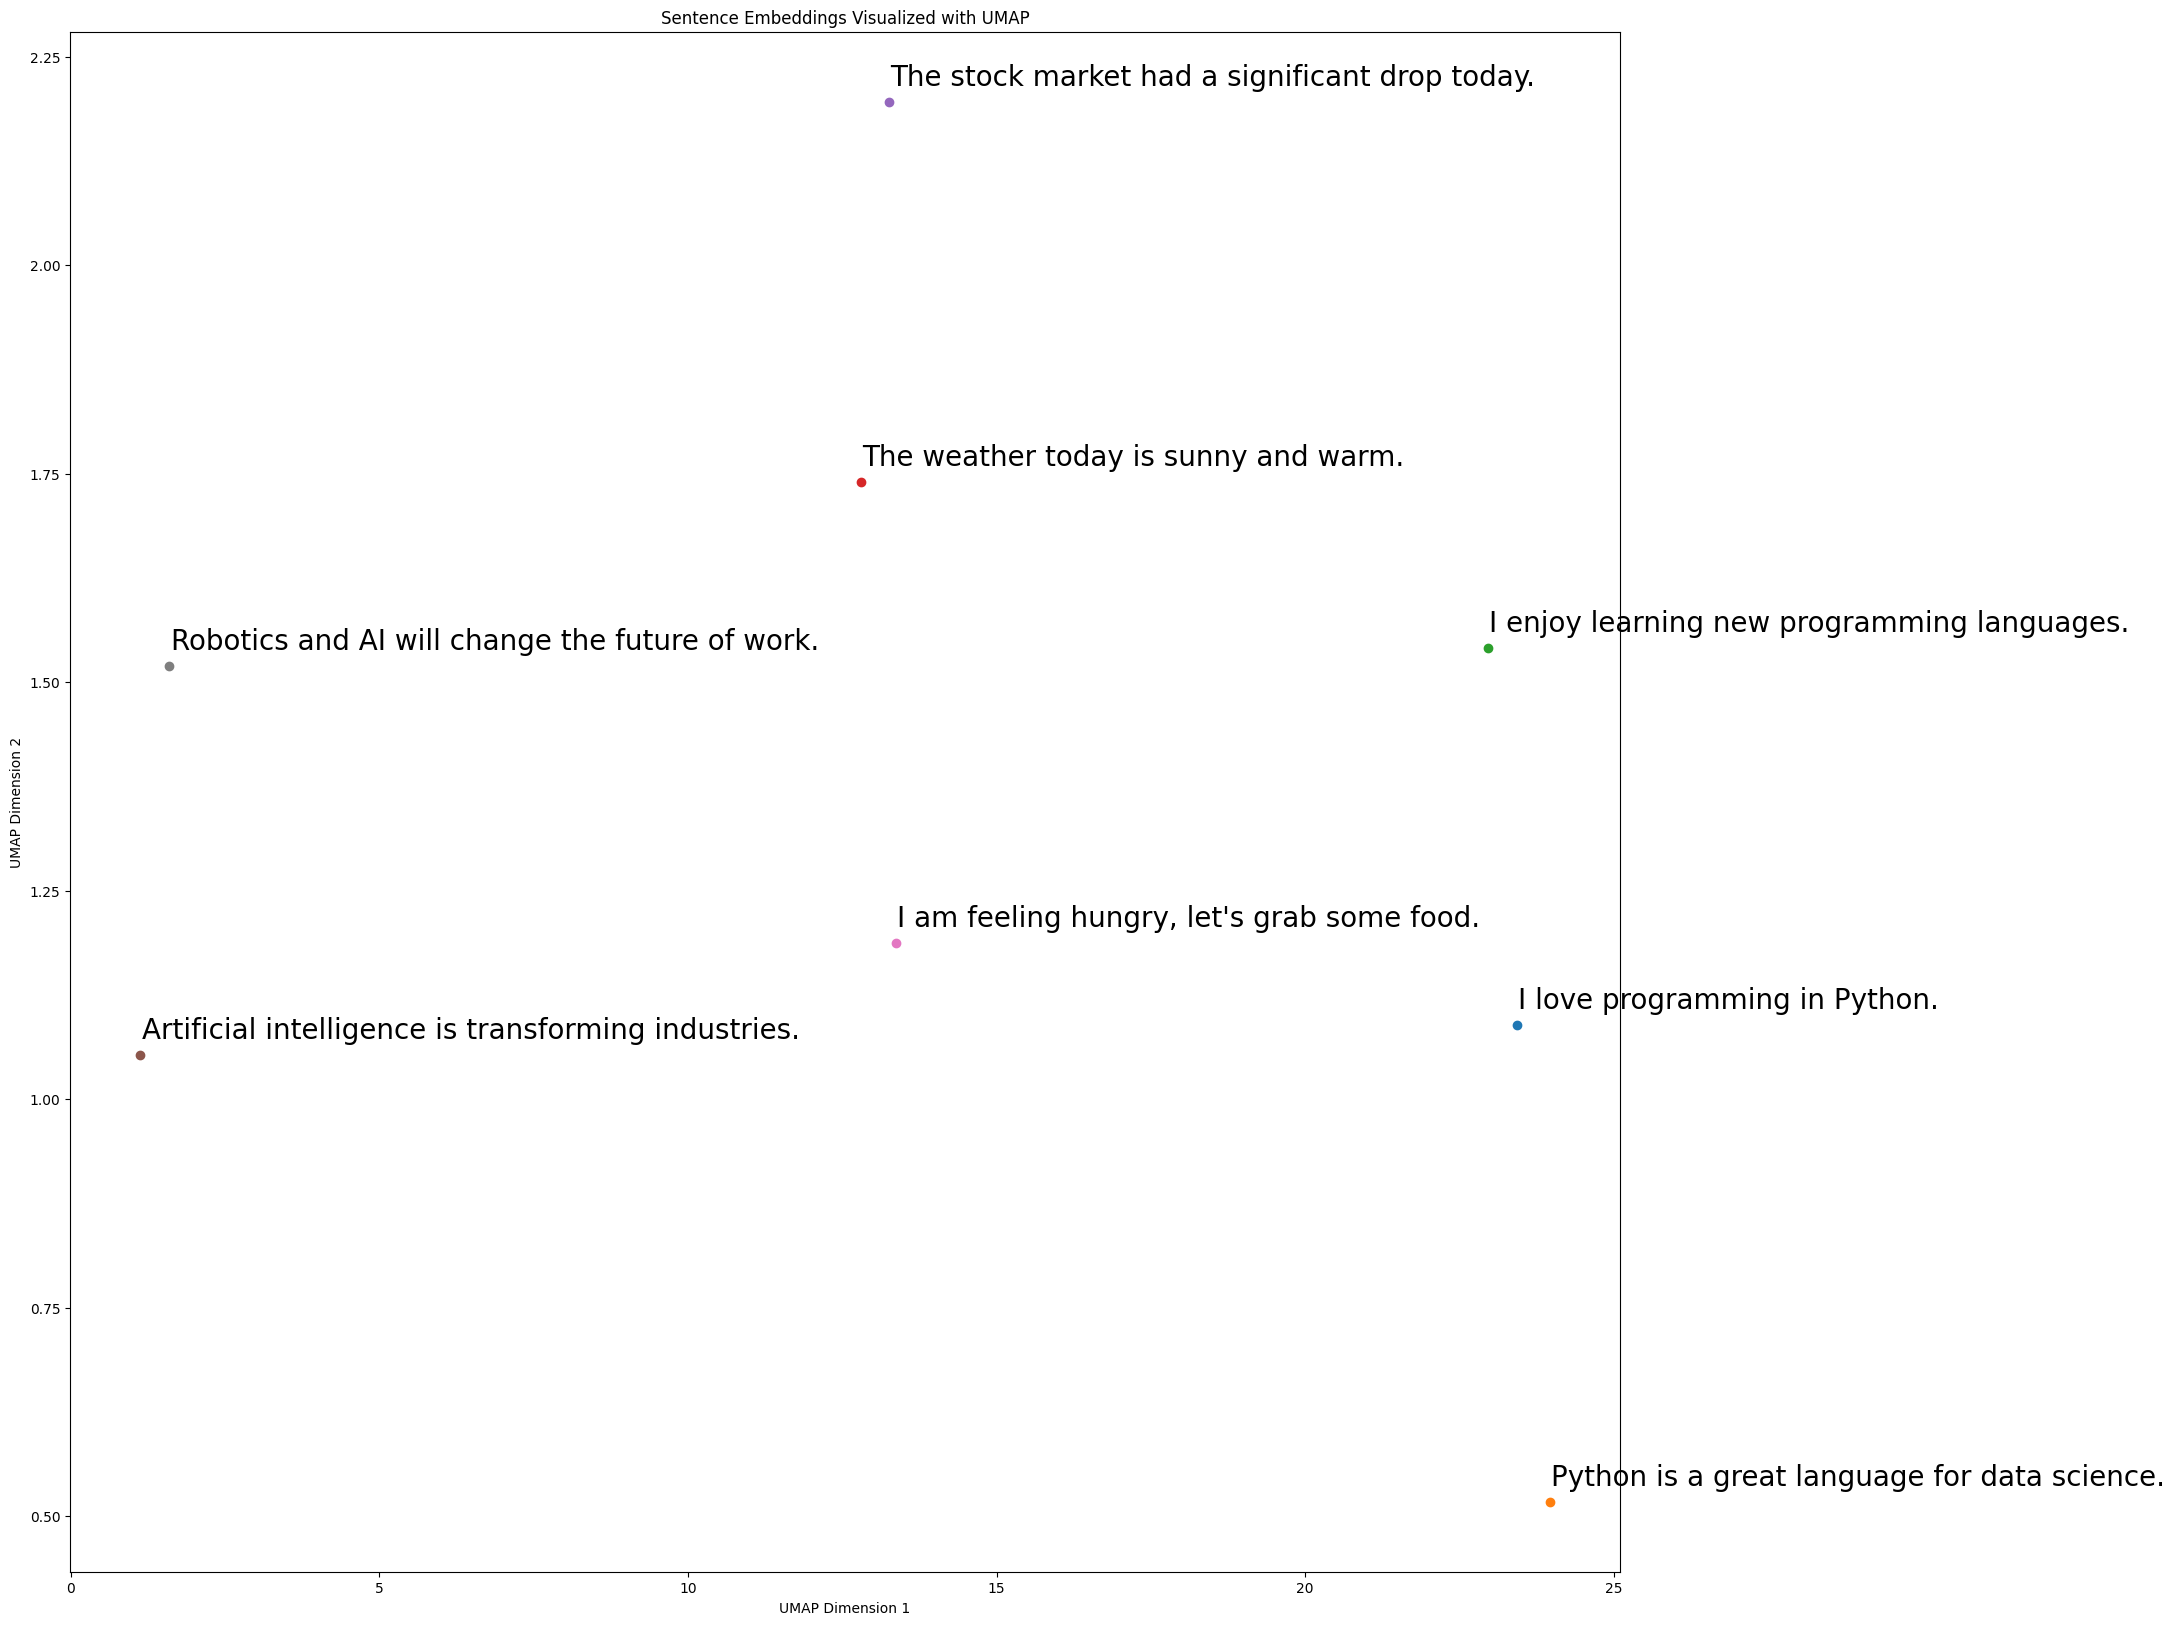

In [29]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

# 3. Get sentence embeddings
embeddings = embedding_model.encode(sentences)

# 4. Reduce dimensionality using UMAP
umap_model = UMAP(n_neighbors=2, min_dist=0.3, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# 5. Plotting
plt.figure(figsize=(20, 20))
for i, sentence in enumerate(sentences):
    plt.scatter(umap_embeddings[i, 0], umap_embeddings[i, 1])
    plt.text(umap_embeddings[i, 0] + 0.02, umap_embeddings[i, 1] + 0.02, sentence, fontsize=20)

plt.title('Sentence Embeddings Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
import os
import torch  

# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(cleaned_text, convert_to_tensor=True, normalize_embeddings=True)
print(embeddings.shape)

save_path = os.path.join(os.getcwd(), "invest_embeddings.pt")  
torch.save(embeddings, save_path)

print(f"✅ Saved embeddings to: {save_path}")

torch.Size([15, 384])
✅ Saved embeddings to: /root/invest-rag/invest_embeddings.pt
